Sau khi dùng Spotify API và xử lý dữ liệu, nhóm đã thu thập được 688431 dòng dữ liệu. Tuy nhiên nhóm vẫn muốn thu thập thêm một vài trường dữ liệu hữu ích cho việc phân tích dữ liệu. Do đó nhóm sử dụng thêm 2 API là Genius API và Rapid API để thu thập một số trường dữ liệu hữu ích như lyrics, ...

### Chọn ra 10000 bài hát tiêu biểu

Vì data gốc thu thập được là 689400 dòng, tuy nhiên Rapid API chỉ giới hạn mỗi lần dùng là 100 bài hát. Do đó nhóm quyết định chọn ra 10.000 bài ngẫu nhiên nhưng phân bố đều ở 10 khoảng điểm popularity (từ 0 tới 100) để phân tích dữ liệu

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import json
import os
import sys
import random


In [2]:
df = pd.read_csv('../data/processed_data.csv')

In [3]:
df

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
0,seasons,5VBjyOQzqlPNgdRPMM6prF,spotify:track:5VBjyOQzqlPNgdRPMM6prF,wave to earth,summer flows 0.02,spotify:album:3NRNR4txhuRLhnQUUlqWXH,0.372,0.273,7,-10.629,...,0.782,0.046300,0.2190,0.165,60.038,spotify:track:5VBjyOQzqlPNgdRPMM6prF,255998,4,79,2020-08
1,Nahuhulog,1t2gvCG4jH1kYE9sX2PrRs,spotify:track:1t2gvCG4jH1kYE9sX2PrRs,Jed Baruelo,Nahuhulog,spotify:album:6djSRoiGffRDFthmbsRgDP,0.612,0.389,4,-12.725,...,0.837,0.004610,0.3060,0.348,125.091,spotify:track:1t2gvCG4jH1kYE9sX2PrRs,227262,4,64,2022-05
2,Ligaya,4IeuTj1pEHuL9vJSiEqEfR,spotify:track:4IeuTj1pEHuL9vJSiEqEfR,mrld,Ligaya,spotify:album:0ccUyUkrIynFO5USku5IHH,0.458,0.533,0,-5.249,...,0.447,0.000000,0.1140,0.343,149.832,spotify:track:4IeuTj1pEHuL9vJSiEqEfR,248800,4,65,2021-10
3,Oceans & Engines,0XZW4ZKXOwo9kCyDpXGNc7,spotify:track:0XZW4ZKXOwo9kCyDpXGNc7,NIKI,Nicole,spotify:album:0Cu6JzzodKQ5Lzccubu5zj,0.371,0.314,1,-8.920,...,0.622,0.000012,0.0893,0.066,95.109,spotify:track:0XZW4ZKXOwo9kCyDpXGNc7,336000,4,72,2022-08
4,Let You Break My Heart Again,709p9UGPAuyImWf1Z3vjRo,spotify:track:709p9UGPAuyImWf1Z3vjRo,Laufey,Let You Break My Heart Again,spotify:album:2YkyuQGoMV2FlG7mFprnRf,0.299,0.142,2,-15.134,...,0.965,0.113000,0.1110,0.123,76.748,spotify:track:709p9UGPAuyImWf1Z3vjRo,269066,4,76,2021-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660374,There Comes A Time,14Hv8TjAech53qG5KnuQto,spotify:track:14Hv8TjAech53qG5KnuQto,Céline Dion,My Love Essential Collection,spotify:album:41IwxoZoITRNmQheABRtwc,0.614,0.603,5,-7.253,...,0.452,0.000000,0.1000,0.115,138.038,spotify:track:14Hv8TjAech53qG5KnuQto,243706,4,22,2008-10
660375,Think Twice,6wgXaOEeRHvNQmab6Zmp6w,spotify:track:6wgXaOEeRHvNQmab6Zmp6w,Céline Dion,My Love Essential Collection,spotify:album:41IwxoZoITRNmQheABRtwc,0.549,0.452,2,-8.131,...,0.403,0.000000,0.1960,0.242,134.296,spotify:track:6wgXaOEeRHvNQmab6Zmp6w,289466,4,35,2008-10
660376,Tú Sí Sabes Quererme (feat. Los Macorinos),6p3yxt0uJJshAS3CT0znQg,spotify:track:6p3yxt0uJJshAS3CT0znQg,Natalia Lafourcade,Musas (Un Homenaje al Folclore Latinoamericano...,spotify:album:30isRfL4u7fowKgTVsydDt,0.664,0.460,1,-10.974,...,0.782,0.000003,0.1760,0.793,170.057,spotify:track:6p3yxt0uJJshAS3CT0znQg,244933,4,62,2017-05
660377,Wedding Day,1JhsuKshsLmKp0AoSC0Cdg,spotify:track:1JhsuKshsLmKp0AoSC0Cdg,Bee Gees,This Is Where I Came In,spotify:album:66AKq70EPA2qfhgEbMQRPU,0.687,0.626,2,-5.724,...,0.167,0.000000,0.1450,0.212,108.973,spotify:track:1JhsuKshsLmKp0AoSC0Cdg,283506,4,0,2001-01


In [4]:
# Tổng số bài mong muốn
total_samples = 10000

bins = range(0, 101, 10)
df['popularity_bin'] = pd.cut(df['popularity'], bins=bins, right=False)

# Tính tỷ lệ phân bổ trong từng khoảng
popularity_distribution = df['popularity_bin'].value_counts(normalize=True)
print(popularity_distribution)

# Tính tỷ lệ phân bổ và số mẫu cần lấy cho từng bin
popularity_distribution = df['popularity_bin'].value_counts(normalize=True)
popularity_distribution = popularity_distribution.sort_index()

# Số mẫu cần lấy cho từng bin
samples_per_bin = (popularity_distribution * total_samples).astype(int)

# Đảm bảo tổng số mẫu đúng bằng 10,000
remaining_samples = total_samples - samples_per_bin.sum()
if remaining_samples > 0:
    # Phân bổ số dư còn lại đều vào các bin (hoặc có thể tùy chỉnh cách phân bổ)
    extra_samples = np.zeros(len(samples_per_bin), dtype=int)
    extra_samples[:remaining_samples] = 1
    samples_per_bin += extra_samples

# Lấy mẫu theo tỷ lệ đã tính toán
eda_df = df.groupby('popularity_bin').apply(
    lambda x: x.sample(n=samples_per_bin[x.name], replace=True)
).reset_index(drop=True)

popularity_bin
[0, 10)      0.287271
[30, 40)     0.176833
[20, 30)     0.159425
[40, 50)     0.137256
[10, 20)     0.124020
[50, 60)     0.076156
[60, 70)     0.029940
[70, 80)     0.007967
[80, 90)     0.001131
[90, 100)    0.000000
Name: proportion, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_27296\515635984.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df = df.groupby('popularity_bin').apply(
C:\Users\DELL\AppData\Local\Temp\ipykernel_27296\515635984.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eda_df = df.groupby('popularity_bin').apply(


In [5]:
eda_df.drop(columns=['popularity_bin'], inplace=True)
eda_df

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
0,Creature,56LGS7W4ji1xq7kVwZLGKm,spotify:track:56LGS7W4ji1xq7kVwZLGKm,Asking Alexandria,From Death To Destiny,spotify:album:3yPGBS6p3GyFb9EySzFyYi,0.476,0.940,4,-3.720,...,0.000088,0.000255,0.1120,0.461,75.990,spotify:track:56LGS7W4ji1xq7kVwZLGKm,194210,4,0,2013-08
1,Saviour (feat. First Aid Kit),1bqziTtf2GPj47mlktYSCp,spotify:track:1bqziTtf2GPj47mlktYSCp,George Ezra,Saviour (feat. First Aid Kit),spotify:album:06W3DE8Zd3CfyO78Nrxqzu,0.582,0.783,7,-6.437,...,0.050500,0.000016,0.2440,0.187,101.009,spotify:track:1bqziTtf2GPj47mlktYSCp,212274,4,0,2018-03
2,You Don't Know,2BlM00LsKY0pFKEChrQa9Y,spotify:track:2BlM00LsKY0pFKEChrQa9Y,Katelyn Tarver,Tired Eyes,spotify:album:7sj87mBaofDr9oJ0C22yFg,0.560,0.315,10,-8.532,...,0.734000,0.000001,0.1050,0.138,78.060,spotify:track:2BlM00LsKY0pFKEChrQa9Y,260851,4,0,2017-03
3,Indoor Kid,2yZIRU8wustsH9QN9qytlM,spotify:track:2yZIRU8wustsH9QN9qytlM,Sløtface,AWAKE/ASLEEP,spotify:album:2SM92RVNoh8JWPf4cSc6iy,0.817,0.615,0,-9.776,...,0.201000,0.000012,0.1240,0.570,127.926,spotify:track:2yZIRU8wustsH9QN9qytlM,170625,4,7,2023-02
4,Copper & Hippie,0lCeHDLulLEJLpZBO89pAK,spotify:track:0lCeHDLulLEJLpZBO89pAK,康姆士(COM’Z),康姆士（COM'Z）,spotify:album:668I5aWYJ4Rz5JAdKHxiZo,0.637,0.640,6,-3.651,...,0.285000,0.000000,0.0945,0.386,110.003,spotify:track:0lCeHDLulLEJLpZBO89pAK,273640,4,1,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,PUSH 2 START,1Cbl3Yq8rHo7hhDQmLQagU,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,Tyla,TYLA +,spotify:album:5QsVRNOKVMCeVAIUoOQJ13,0.683,0.814,2,-3.505,...,0.277000,0.008260,0.0858,0.758,93.482,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,156825,4,81,2024-10
9996,MILLION DOLLAR BABY,5AJ9hqTS2wcFQCELCFRO7A,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,Tommy Richman,MILLION DOLLAR BABY,spotify:album:2Z1gnUf3nbn6DtwZSUIH54,0.852,0.697,1,-5.520,...,0.097300,0.000370,0.0678,0.919,138.029,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,155151,4,88,2024-04
9997,Slow It Down,51eSHglvG1RJXtL3qI5trr,spotify:track:51eSHglvG1RJXtL3qI5trr,Benson Boone,Fireworks & Rollerblades,spotify:album:168CdR21lfn0TTyw1Pkdcm,0.432,0.583,8,-4.682,...,0.174000,0.000000,0.0933,0.544,181.489,spotify:track:51eSHglvG1RJXtL3qI5trr,161831,4,85,2024-04
9998,"Paint It, Black",63T7DJ1AFDD6Bn8VzG6JE8,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,The Rolling Stones,Aftermath,spotify:album:72qrnM4yUNMDDlWiqKc8iY,0.464,0.795,1,-9.267,...,0.049300,0.002440,0.3990,0.612,158.691,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,202266,4,81,1966-04


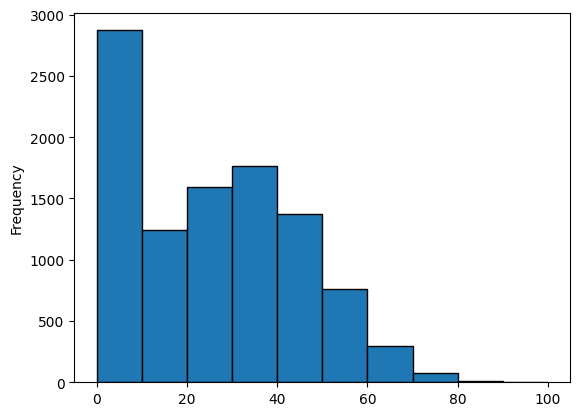

In [7]:
# Kiểm pha phân bố popularity bằng biểu đồ
import matplotlib.pyplot as plt

eda_df['popularity'].plot.hist(bins=bins, edgecolor='black')
plt.show()


In [8]:
eda_df.to_csv('../data/eda_data_withoutgeniusID.csv', index=False)

### Lấy genres

In [3]:
import requests
import json

def request_song_info(song_title, artist_name):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + '5l4zx-dfAx4KV5iNuGUQs2QJ_YsaVqIY_eStOF_CJLIISlt8jZcZkPaQmGCyES2_'}
    search_url = base_url + '/search'
    data = {'q': song_title + ' ' + artist_name}
    response = requests.get(search_url, params=data, headers=headers)

    return response

In [14]:
id = []
count = 0
for song, artist in zip(eda_df['track_name'], eda_df['artist_name']):
  response = request_song_info(song, artist)
  if response.status_code == 200 :
    json = response.json()
    if(json['response']['hits'] != []):
      id.append(json['response']['hits'][0]['result']['id'])
    else:
      id.append('-1')
  else:
    id.append('-1')
  print(count + 1)
  count+=1
eda_df['genius_id'] = id
eda_df.to_csv('../data/eda_data.csv', index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [4]:
eda_df_first = eda_df[:5000]
eda_df_first

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
0,Creature,56LGS7W4ji1xq7kVwZLGKm,spotify:track:56LGS7W4ji1xq7kVwZLGKm,Asking Alexandria,From Death To Destiny,spotify:album:3yPGBS6p3GyFb9EySzFyYi,0.476,0.940,4,-3.720,...,0.000088,0.000255,0.1120,0.461,75.990,spotify:track:56LGS7W4ji1xq7kVwZLGKm,194210,4,0,2013-08
1,Saviour (feat. First Aid Kit),1bqziTtf2GPj47mlktYSCp,spotify:track:1bqziTtf2GPj47mlktYSCp,George Ezra,Saviour (feat. First Aid Kit),spotify:album:06W3DE8Zd3CfyO78Nrxqzu,0.582,0.783,7,-6.437,...,0.050500,0.000016,0.2440,0.187,101.009,spotify:track:1bqziTtf2GPj47mlktYSCp,212274,4,0,2018-03
2,You Don't Know,2BlM00LsKY0pFKEChrQa9Y,spotify:track:2BlM00LsKY0pFKEChrQa9Y,Katelyn Tarver,Tired Eyes,spotify:album:7sj87mBaofDr9oJ0C22yFg,0.560,0.315,10,-8.532,...,0.734000,0.000001,0.1050,0.138,78.060,spotify:track:2BlM00LsKY0pFKEChrQa9Y,260851,4,0,2017-03
3,Indoor Kid,2yZIRU8wustsH9QN9qytlM,spotify:track:2yZIRU8wustsH9QN9qytlM,Sløtface,AWAKE/ASLEEP,spotify:album:2SM92RVNoh8JWPf4cSc6iy,0.817,0.615,0,-9.776,...,0.201000,0.000012,0.1240,0.570,127.926,spotify:track:2yZIRU8wustsH9QN9qytlM,170625,4,7,2023-02
4,Copper & Hippie,0lCeHDLulLEJLpZBO89pAK,spotify:track:0lCeHDLulLEJLpZBO89pAK,康姆士(COM’Z),康姆士（COM'Z）,spotify:album:668I5aWYJ4Rz5JAdKHxiZo,0.637,0.640,6,-3.651,...,0.285000,0.000000,0.0945,0.386,110.003,spotify:track:0lCeHDLulLEJLpZBO89pAK,273640,4,1,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Let the Music Play,6MiBNNFetK40dpAXaBOizm,spotify:track:6MiBNNFetK40dpAXaBOizm,Stick Figure,The Reprise Sessions,spotify:album:4UEVPHw9aIh2hc0fqbS9pN,0.782,0.627,10,-6.996,...,0.016300,0.487000,0.0935,0.848,137.963,spotify:track:6MiBNNFetK40dpAXaBOizm,279960,4,27,2010-08
4996,Here we go,0BycSgjwTyMj3qKR9D9XqV,spotify:track:0BycSgjwTyMj3qKR9D9XqV,Lij9,Here we go,spotify:album:0vO2lgY2V5X72AfVrjOzH6,0.387,0.525,10,-12.425,...,0.098200,0.000000,0.1420,0.262,180.252,spotify:track:0BycSgjwTyMj3qKR9D9XqV,106736,4,22,2024-07
4997,Don't Like Me,4EgRVE9vfxlNgjG6fNpBuL,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,Chris Travis,Water World 2,spotify:album:27uJCAFag37CgoMd5Asj1F,0.893,0.632,8,-8.410,...,0.169000,0.000002,0.0546,0.571,140.098,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,102752,4,27,2024-10
4998,"My Jesus, I Love Thee",5Ws9Mkn4ClkjMllKVAvkCJ,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,Casting Crowns,Glorious Day: Hymns of Faith,spotify:album:3hB7IALT7uaNMC6Ol0elbo,0.241,0.353,1,-10.863,...,0.812000,0.001140,0.0979,0.123,94.180,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,271786,4,29,2015-07


In [ ]:
!pip install fake-useragent

In [ ]:
# Setup random User-Agent
user_agents = UserAgent()

In [ ]:
def get_genre_with_header(song, artist):
    url = "https://itunes.apple.com/search"
    params = {"term": f"{song} {artist}", "entity": "song", "limit": 1}
    headers = {"User-Agent": user_agents.random}  # Randomized User-Agent
    
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    
    try:
        response = session.get(url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data.get("resultCount", 0) > 0:
                return data["results"][0].get("primaryGenreName", "")
            return "Not Found"
        else:
            print(f"API error {response.status_code}: {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    return "Error"

In [5]:
# Fetch genres with sleep and batch delay
genres = []
for i, (song, artist) in enumerate(zip(eda_df_first['track_name'], eda_df_first['artist_name'])):
    genre = get_genre_with_header(song, artist)
    genres.append(genre)
    print(i, genre)

    time.sleep(random.uniform(0.8, 1.5))  # Random delay to prevent detection

    if i > 0 and i % 30 == 0:
        print("Taking a longer break...")
        time.sleep(random.uniform(15, 25))  # Periodic longer delay

# Assign 'genre' column back to DataFrame
eda_df_first['genre'] = genres

In [15]:
import requests
import pandas as pd

# Thông tin API
LAST_FM_API_KEY = "8f0dc6ae1772040e7f891ceb002d419d"
BASE_URL = "http://ws.audioscrobbler.com/2.0/"

def get_track_tags(artist_name, track_name):
    """
    Lấy tags của một bài hát từ Last.fm.
    """
    params = {
        "method": "track.getTopTags",
        "api_key": LAST_FM_API_KEY,
        "artist": artist_name,
        "track": track_name,
        "format": "json"
    }
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Kiểm tra xem có tags không
        if "toptags" in data and "tag" in data["toptags"]:
            tags = [tag["name"] for tag in data["toptags"]["tag"]]
            return tags
        else:
            return []
    except Exception as e:
        print(f"Lỗi: {e}")
        return []

# Ví dụ sử dụng
artist = "Asking Alexandria"
track = "Creature"

tags = []
for i in range(len(eda_df_first)):
    artist = eda_df_first['artist_name'][i]
    track = eda_df_first['track_name'][i]
    tag = get_track_tags(artist, track)
    tags.append(tag)
    print(i, tag)


eda_df_first['tags'] = tags


0 ['post-hardcore', 'metalcore', 'Favorite', 'mentally disturbed', '3 stars', '6 of 10 stars', '8 stars', 'pos-hardcore', 'asking alexandria', 'danny worsnop', 'donita dunes']
1 []
2 ['K Artist']
3 []
4 []
5 []
6 []
7 []
8 ['badass', 'best of 2015']
9 []
10 []
11 ['Hip-Hop', 'hip hop', 'mf doom', 'Scooby Doo', 'rap', 'underground hip-hop', 'genius', 'chill', 'Awesome', 'Shaggy', 'exclamation mark', 'urban pimp assault', 'sped up', 'MySpotigramBot', 'chillout', 'calm', 'underground rap', 'experimental hip hop', 'turntablism', 'weird', 'drone', 'g', 'hiphop', 'underground', 'abstract hip hop', 'hey', 'boom bap', 'east coast hip hop', 'stream', 'dope like fuckin heroin', 'Radio Phantom Zone', 'wykurwiste', 'best beats', 'felines', 'MJ-just playin tunes', 'operation doomsday', 'heisse scheibe', 'Scooby dooby doo', 'freimauris hip hop', 'skin cats', 'kss1984 - good', 'bummingAndHugging', 'capmanslovedtracks', '-1001854528204']
12 ['indie', 'indie rock', 'british', 'Art brut', 'rock', 'alter

C:\Users\DELL\AppData\Local\Temp\ipykernel_20760\3148452522.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df_first['tags'] = tags


In [30]:
eda_df_first

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date,tags
0,Creature,56LGS7W4ji1xq7kVwZLGKm,spotify:track:56LGS7W4ji1xq7kVwZLGKm,Asking Alexandria,From Death To Destiny,spotify:album:3yPGBS6p3GyFb9EySzFyYi,0.476,0.940,4,-3.720,...,0.000255,0.1120,0.461,75.990,spotify:track:56LGS7W4ji1xq7kVwZLGKm,194210,4,0,2013-08,"[post-hardcore, metalcore, Favorite, mentally ..."
1,Saviour (feat. First Aid Kit),1bqziTtf2GPj47mlktYSCp,spotify:track:1bqziTtf2GPj47mlktYSCp,George Ezra,Saviour (feat. First Aid Kit),spotify:album:06W3DE8Zd3CfyO78Nrxqzu,0.582,0.783,7,-6.437,...,0.000016,0.2440,0.187,101.009,spotify:track:1bqziTtf2GPj47mlktYSCp,212274,4,0,2018-03,[]
2,You Don't Know,2BlM00LsKY0pFKEChrQa9Y,spotify:track:2BlM00LsKY0pFKEChrQa9Y,Katelyn Tarver,Tired Eyes,spotify:album:7sj87mBaofDr9oJ0C22yFg,0.560,0.315,10,-8.532,...,0.000001,0.1050,0.138,78.060,spotify:track:2BlM00LsKY0pFKEChrQa9Y,260851,4,0,2017-03,[K Artist]
3,Indoor Kid,2yZIRU8wustsH9QN9qytlM,spotify:track:2yZIRU8wustsH9QN9qytlM,Sløtface,AWAKE/ASLEEP,spotify:album:2SM92RVNoh8JWPf4cSc6iy,0.817,0.615,0,-9.776,...,0.000012,0.1240,0.570,127.926,spotify:track:2yZIRU8wustsH9QN9qytlM,170625,4,7,2023-02,[]
4,Copper & Hippie,0lCeHDLulLEJLpZBO89pAK,spotify:track:0lCeHDLulLEJLpZBO89pAK,康姆士(COM’Z),康姆士（COM'Z）,spotify:album:668I5aWYJ4Rz5JAdKHxiZo,0.637,0.640,6,-3.651,...,0.000000,0.0945,0.386,110.003,spotify:track:0lCeHDLulLEJLpZBO89pAK,273640,4,1,2014-04,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Let the Music Play,6MiBNNFetK40dpAXaBOizm,spotify:track:6MiBNNFetK40dpAXaBOizm,Stick Figure,The Reprise Sessions,spotify:album:4UEVPHw9aIh2hc0fqbS9pN,0.782,0.627,10,-6.996,...,0.487000,0.0935,0.848,137.963,spotify:track:6MiBNNFetK40dpAXaBOizm,279960,4,27,2010-08,"[reggae, reggae music, QQT, temazo lounge, get..."
4996,Here we go,0BycSgjwTyMj3qKR9D9XqV,spotify:track:0BycSgjwTyMj3qKR9D9XqV,Lij9,Here we go,spotify:album:0vO2lgY2V5X72AfVrjOzH6,0.387,0.525,10,-12.425,...,0.000000,0.1420,0.262,180.252,spotify:track:0BycSgjwTyMj3qKR9D9XqV,106736,4,22,2024-07,[]
4997,Don't Like Me,4EgRVE9vfxlNgjG6fNpBuL,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,Chris Travis,Water World 2,spotify:album:27uJCAFag37CgoMd5Asj1F,0.893,0.632,8,-8.410,...,0.000002,0.0546,0.571,140.098,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,102752,4,27,2024-10,[]
4998,"My Jesus, I Love Thee",5Ws9Mkn4ClkjMllKVAvkCJ,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,Casting Crowns,Glorious Day: Hymns of Faith,spotify:album:3hB7IALT7uaNMC6Ol0elbo,0.241,0.353,1,-10.863,...,0.001140,0.0979,0.123,94.180,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,271786,4,29,2015-07,[]


In [43]:
eda_df_first.to_csv('../data/eda_data_first.csv', index=False)

In [40]:
non_empty_tags = eda_df_first['tags'].apply(lambda x: len(x) > 0)

In [42]:
non_empty_tags.value_counts()

tags
False    3808
True     1192
Name: count, dtype: int64

In [32]:
all_tags =  [tag for tags in eda_df_first['tags'] for tag in tags]
all_tags = pd.Series(all_tags)
tag_counts = all_tags.value_counts()
tag_counts

pop                              350
rock                             264
Love                             164
male vocalists                   158
favorites                        153
                                ... 
teenager                           1
mentally disturbed                 1
letitplay                          1
must be played at full volume      1
donita dunes                       1
Name: count, Length: 11435, dtype: int64

In [44]:
eda_df_last = eda_df[5000:]
eda_df_last

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
5000,Come On In My Kitchen,7wmX9k2kWK3PrfBbTgOzZV,spotify:track:7wmX9k2kWK3PrfBbTgOzZV,Crooked Still,Shaken By A Low Sound,spotify:album:1MXfI5PVHDjkZJrlM9aFkp,0.629,0.218,6,-12.951,...,0.7100,0.123000,0.1030,0.235,142.736,spotify:track:7wmX9k2kWK3PrfBbTgOzZV,299213,4,28,2006-08
5001,Infiltrate,5n71qHTwWmbYopWjTXuU3z,spotify:track:5n71qHTwWmbYopWjTXuU3z,Phlocalyst,Breakup,spotify:album:78A7EqSU92xHDKZy3JzJ8c,0.665,0.249,1,-12.285,...,0.3160,0.926000,0.1260,0.177,82.009,spotify:track:5n71qHTwWmbYopWjTXuU3z,143446,4,29,2024-08
5002,Vana,6r5Cyh4URoP8SnzgYwe4LP,spotify:track:6r5Cyh4URoP8SnzgYwe4LP,Vitico Flow,Vibe Cycle,spotify:album:38JT8w7YlH8HlJC5uzdf3O,0.669,0.795,2,-11.000,...,0.1310,0.813000,0.1370,0.325,126.098,spotify:track:6r5Cyh4URoP8SnzgYwe4LP,137038,4,23,2024-05
5003,Lose Your Love (Dirty Projectors x Chromeo) - ...,6VLQWIRjq7UjmTaN3ra51Q,spotify:track:6VLQWIRjq7UjmTaN3ra51Q,Dirty Projectors,Lose Your Love (Dirty Projectors x Chromeo) [C...,spotify:album:6Y6YeVV1awYIyWDl8afa0f,0.835,0.785,8,-4.575,...,0.0988,0.000192,0.1190,0.847,118.002,spotify:track:6VLQWIRjq7UjmTaN3ra51Q,222875,4,20,2020-10
5004,When I Wake Up,6TYaTUkuerVnw7neS9bpsY,spotify:track:6TYaTUkuerVnw7neS9bpsY,Iggy,When I Wake Up,spotify:album:4q0YaMUZW9at7ItLHFcB7c,0.663,0.628,5,-8.583,...,0.4540,0.003360,0.0910,0.281,119.992,spotify:track:6TYaTUkuerVnw7neS9bpsY,175266,4,26,2016-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,PUSH 2 START,1Cbl3Yq8rHo7hhDQmLQagU,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,Tyla,TYLA +,spotify:album:5QsVRNOKVMCeVAIUoOQJ13,0.683,0.814,2,-3.505,...,0.2770,0.008260,0.0858,0.758,93.482,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,156825,4,81,2024-10
9996,MILLION DOLLAR BABY,5AJ9hqTS2wcFQCELCFRO7A,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,Tommy Richman,MILLION DOLLAR BABY,spotify:album:2Z1gnUf3nbn6DtwZSUIH54,0.852,0.697,1,-5.520,...,0.0973,0.000370,0.0678,0.919,138.029,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,155151,4,88,2024-04
9997,Slow It Down,51eSHglvG1RJXtL3qI5trr,spotify:track:51eSHglvG1RJXtL3qI5trr,Benson Boone,Fireworks & Rollerblades,spotify:album:168CdR21lfn0TTyw1Pkdcm,0.432,0.583,8,-4.682,...,0.1740,0.000000,0.0933,0.544,181.489,spotify:track:51eSHglvG1RJXtL3qI5trr,161831,4,85,2024-04
9998,"Paint It, Black",63T7DJ1AFDD6Bn8VzG6JE8,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,The Rolling Stones,Aftermath,spotify:album:72qrnM4yUNMDDlWiqKc8iY,0.464,0.795,1,-9.267,...,0.0493,0.002440,0.3990,0.612,158.691,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,202266,4,81,1966-04


In [47]:
import requests
import pandas as pd

# Thông tin API
LAST_FM_API_KEY = "8f0dc6ae1772040e7f891ceb002d419d"
BASE_URL = "http://ws.audioscrobbler.com/2.0/"

def get_track_tags(artist_name, track_name):
    """
    Lấy tags của một bài hát từ Last.fm.
    """
    params = {
        "method": "track.getTopTags",
        "api_key": LAST_FM_API_KEY,
        "artist": artist_name,
        "track": track_name,
        "format": "json"
    }
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Kiểm tra xem có tags không
        if "toptags" in data and "tag" in data["toptags"]:
            tags = [tag["name"] for tag in data["toptags"]["tag"]]
            return tags
        else:
            return []
    except Exception as e:
        print(f"Lỗi: {e}")
        return []

tags = []
for i in range(5000,len(eda_df_last)+5000):
    artist = eda_df_last['artist_name'][i]
    track = eda_df_last['track_name'][i]
    tag = get_track_tags(artist, track)
    tags.append(tag)
    print(i, tag)


eda_df_last['tags'] = tags


5000 ['folk', 'bluegrass', 'country', 'americana', 'Mellow', 'oh yes', 'locker', 'smokin hot', 'double-ender 4']
5001 []
5002 []
5003 []
5004 []
5005 []
5006 ['electronic', 'hardstyle']
5007 []
5008 []
5009 ['pop']
5010 []
5011 []
5012 []
5013 []
5014 []
5015 []
5016 ['chillout', 'dub']
5017 ['Progressive metal']
5018 []
5019 []
5020 []
5021 []
5022 []
5023 []
5024 []
5025 []
5026 []
5027 []
5028 []
5029 ['punk rock', 'melodic hardcore', 'punk', 'rock', 'hardcore', 'Rise Against', 'american', 'hardcore punk', 'alternative rock', '2008', '2000s', 'Matt Skiba', '00s', '6 of 10 stars', 'melodic punk', 'musik zum joggen', 'alternative', 'favorite songs', 'hard rock', 'favorites', 'Energetic', 'male vocalist', 'male vocalists', 'chicago', 'english lyrics', '4 of 10 stars', 'Favourite Songs', 'Illinois', '<3', 'biology', 'rocking out', 'best songs', 'hardcore-punk', 'exceptional', '2000s rock', 'i want to see this live', 'o kurwa', 'wyjebiste', 'klkl', 'Voices of rock', 'stephsfavs', 'guest 

C:\Users\DELL\AppData\Local\Temp\ipykernel_20760\2839329524.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df_last['tags'] = tags


In [49]:
eda_df_last.to_csv('../data/eda_data_last.csv', index=False)